In [315]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, time, json, math, glob
import plotly.graph_objects as go
import scipy.stats as stats
from tqdm.notebook import tqdm_notebook
from statsmodels.stats.multicomp import pairwise_tukeyhsd
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2020.csv.gz',
 'final_tmdb_data_2021.csv.gz',
 'final_tmdb_data_2022.csv.gz',
 'title_akas.csv.gz',
 'title_akas2.csv.gz',
 'title_basics.csv.gz',
 'title_basics2.csv.gz',
 'title_basics_combined.csv.gz',
 'title_ratings.csv.gz',
 'title_ratings2.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2020.json',
 'tmdb_api_results_2021.json',
 'tmdb_api_results_2022.json',
 'tmdb_results_combined.csv.gz']

Load and clean data to get years during Covid, 2020-2022, to use for later 2 additional hypothesis testing

In [28]:
#load api credentials
import json
with open('/Users/abate/.secret/tmdb_api.json', 'r') as f:
    login = json.load(f)
#display the keys of the loaded dict
login.keys()

dict_keys(['api-key'])

In [29]:
#set api key to api credential
import tmdbsimple as tmdb
tmdb.API_KEY = login['api-key']

In [30]:
basics_url="https://datasets.imdbws.com/title.basics.tsv.gz"
ratings_url="https://datasets.imdbws.com/title.ratings.tsv.gz"
akas_url="https://datasets.imdbws.com/title.akas.tsv.gz"

In [31]:
basics2 = pd.read_csv(basics_url,sep='\t', low_memory=False)

ratings2 = pd.read_csv(ratings_url,sep='\t', low_memory=False)

akas2 = pd.read_csv(akas_url,sep='\t', low_memory=False)

Basics Cleaning

In [32]:
#reviewing data and checking for missing values
print(basics2.info(), '\n')
print(basics2.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9216766 entries, 0 to 9216765
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         object
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: object(9)
memory usage: 632.9+ MB
None 

tconst             0
titleType          0
primaryTitle      11
originalTitle     11
isAdult            0
startYear          0
endYear            0
runtimeMinutes     0
genres            10
dtype: int64


In [33]:
basics2.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [34]:
#Replace "\N" with np.nan
basics2.replace({'\\N':np.nan}, inplace=True)

In [35]:
#confirming missing values in runtimeMinutes column
basics2[basics2['runtimeMinutes'].isnull()]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
18,tt0000019,short,The Clown Barber,The Clown Barber,0,1898,NaN,NaN,"Comedy,Short"
22,tt0000024,short,Opening of the Kiel Canal,Opening of the Kiel Canal,0,1895,NaN,NaN,"News,Short"
23,tt0000025,short,The Oxford and Cambridge University Boat Race,The Oxford and Cambridge University Boat Race,0,1895,NaN,NaN,"News,Short,Sport"
36,tt0000038,short,The Ball Game,The Ball Game,0,1898,NaN,NaN,"Documentary,Short,Sport"
37,tt0000039,short,Barnet Horse Fair,Barnet Horse Fair,0,1896,NaN,NaN,Short
...,...,...,...,...,...,...,...,...,...
9216759,tt9916844,tvEpisode,Episode #3.15,Episode #3.15,0,2010,NaN,NaN,"Action,Drama,Family"
9216760,tt9916846,tvEpisode,Episode #3.18,Episode #3.18,0,2010,NaN,NaN,"Action,Drama,Family"
9216761,tt9916848,tvEpisode,Episode #3.17,Episode #3.17,0,2010,NaN,NaN,"Action,Drama,Family"
9216762,tt9916850,tvEpisode,Episode #3.19,Episode #3.19,0,2010,NaN,NaN,"Action,Drama,Family"


In [36]:
#Eliminate movies that are null for runtimeMinutes
basics2 = basics2.dropna(axis=0, subset=['runtimeMinutes'])

In [37]:
basics2[basics2['genres'].isnull()]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
498,tt0000502,movie,Bohemios,Bohemios,0,1905,NaN,100,NaN
1346,tt0001358,movie,Peder Tordenskjold,Peder Tordenskjold,0,1910,NaN,34,NaN
1616,tt0001630,movie,Der fremde Vogel,Der fremde Vogel,0,1911,NaN,45,NaN
1739,tt0001756,movie,Lucha por la herencia,Lucha por la herencia,0,1911,NaN,92,NaN
2069,tt0002094,movie,Charles IV,Charles IV,0,1912,NaN,50,NaN
...,...,...,...,...,...,...,...,...,...
9215382,tt9913834,movie,Hiniku: Nure nawazeme,Hiniku: Nure nawazeme,0,1981,NaN,64,NaN
9215403,tt9913878,movie,Document porno: Yubi ijime,Document porno: Yubi ijime,0,1981,NaN,61,NaN
9215978,tt9915130,movie,Meet John Doe,Meet John Doe,0,NaN,NaN,120,NaN
9216421,tt9916134,movie,The Thing in the Bag,The Thing in the Bag,0,NaN,NaN,78,NaN


In [38]:
#Eliminate movies that are null for genres
basics2 = basics2.dropna(axis=0, subset=['genres'])

In [39]:
#reviewing subtypes of titleType column
basics2['titleType'].value_counts()

tvEpisode       1066995
short            575827
movie            367806
video            175375
tvMovie           88460
tvSeries          86782
tvSpecial         16546
tvMiniSeries      16128
tvShort            9400
videoGame           301
Name: titleType, dtype: int64

In [40]:
#keep only titleType==Movie
basics2 = basics2.drop(basics2[basics2['titleType'] != 'movie'].index)

In [41]:
#confirming only movie subtype in titleType column
basics2['titleType'].value_counts()

movie    367806
Name: titleType, dtype: int64

In [42]:
#drop all values less than 2020
basics2 = basics2.drop(basics2[basics2['startYear'] < '2020'].index)

In [43]:
#exclude movies that are included in the documentary category.
is_documentary = basics2['genres'].str.contains('documentary',case=False)
basics2 = basics2[~is_documentary]

In [44]:
#confirm documentary not in genres column
starts_doc = basics2['genres'].str.startswith('doc', 'Doc')

In [45]:
basics2[starts_doc]

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres


Akas Cleaning

In [46]:
#Replace "\N" with np.nan
akas2.replace({'\\N':np.nan}, inplace=True)

In [47]:
akas2.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,1,Карменсіта,UA,NaN,imdbDisplay,NaN,0
1,tt0000001,2,Carmencita,DE,NaN,NaN,literal title,0
2,tt0000001,3,Carmencita - spanyol tánc,HU,NaN,imdbDisplay,NaN,0
3,tt0000001,4,Καρμενσίτα,GR,NaN,imdbDisplay,NaN,0
4,tt0000001,5,Карменсита,RU,NaN,imdbDisplay,NaN,0


In [48]:
#review US count in region column
akas2.loc[akas2['region'] == 'US']

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
5,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0
14,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0
33,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0
36,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0
41,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0
...,...,...,...,...,...,...,...,...
33155491,tt9916702,1,Loving London: The Playground,US,NaN,NaN,NaN,0
33155528,tt9916720,10,The Demonic Nun,US,NaN,tv,NaN,0
33155530,tt9916720,12,The Nun 2,US,NaN,imdbDisplay,NaN,0
33155547,tt9916756,1,Pretty Pretty Black Girl,US,NaN,imdbDisplay,NaN,0


In [49]:
#drop all regions not US
akas2 = akas2.drop(akas2[akas2['region'] != 'US'].index)

In [50]:
#confirm only US region
akas2['region'].value_counts()

US    1348370
Name: region, dtype: int64

Ratings Cleaning

In [51]:
#reviewing data and checking for missing values
print(ratings2.info(), '\n')
print(ratings2.isna().sum())

#no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259757 entries, 0 to 1259756
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1259757 non-null  object 
 1   averageRating  1259757 non-null  float64
 2   numVotes       1259757 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 28.8+ MB
None 

tconst           0
averageRating    0
numVotes         0
dtype: int64


In [52]:
#filter basics2 df based on akas2 df

#filter the basics table down to only include the US by using the filter akas dataframe
keepers2 =basics2['tconst'].isin(akas2['titleId'])
keepers2

60162      False
61093       True
78420      False
86367      False
92045      False
           ...  
9215557    False
9215897    False
9216447     True
9216486    False
9216531     True
Name: tconst, Length: 26117, dtype: bool

In [53]:
basics2 = basics2[keepers2]
basics2

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
61093,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020,NaN,70,Drama
117691,tt0120589,movie,A Dangerous Practice,A Dangerous Practice,0,2022,NaN,108,Drama
137179,tt0141390,movie,Ira's Ordeal,Ira's Ordeal,1,NaN,NaN,60,Adult
148504,tt0153198,movie,Tortured Present,Tortured Present,1,NaN,NaN,60,Adult
172679,tt0178965,movie,Vampires,Vampires,0,NaN,NaN,80,Horror
...,...,...,...,...,...,...,...,...,...
9211169,tt9904802,movie,Enemy Lines,Enemy Lines,0,2020,NaN,92,War
9212579,tt9907782,movie,The Cursed,Eight for Silver,0,2021,NaN,111,"Fantasy,Horror,Mystery"
9214123,tt9911196,movie,The Marriage Escape,De beentjes van Sint-Hildegard,0,2020,NaN,103,"Comedy,Drama"
9216447,tt9916190,movie,Safeguard,Safeguard,0,2020,NaN,95,"Action,Adventure,Thriller"


Create Data Folder for years 2020-2022

In [54]:
#save current basics2 dataframe to file.
basics2.to_csv("Data/title_basics2.csv.gz",compression='gzip',index=False)

In [55]:
#open saved file and preview again
basics2 = pd.read_csv("Data/title_basics2.csv.gz", low_memory = False)
basics2.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,El Tango del Viudo y Su Espejo Deformante,0,2020.0,NaN,70,Drama
1,tt0120589,movie,A Dangerous Practice,A Dangerous Practice,0,2022.0,NaN,108,Drama
2,tt0141390,movie,Ira's Ordeal,Ira's Ordeal,1,NaN,NaN,60,Adult
3,tt0153198,movie,Tortured Present,Tortured Present,1,NaN,NaN,60,Adult
4,tt0178965,movie,Vampires,Vampires,0,NaN,NaN,80,Horror


In [56]:
#save current ratings dataframe to file.
ratings2.to_csv("Data/title_ratings2.csv.gz",compression='gzip',index=False)

In [57]:
#open saved file and preview again
ratings2 = pd.read_csv("Data/title_ratings2.csv.gz", low_memory = False)
ratings2.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1910
1,tt0000002,5.8,256
2,tt0000003,6.5,1712
3,tt0000004,5.6,169
4,tt0000005,6.2,2527


In [58]:
#save current akas2 dataframe to file.
akas2.to_csv("Data/title_akas2.csv.gz",compression='gzip',index=False)

In [59]:
#open saved file and preview again
akas2 = pd.read_csv("Data/title_akas2.csv.gz", low_memory = False)
akas2.head()

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
0,tt0000001,6,Carmencita,US,NaN,imdbDisplay,NaN,0.0
1,tt0000002,7,The Clown and His Dogs,US,NaN,NaN,literal English title,0.0
2,tt0000005,10,Blacksmith Scene,US,NaN,imdbDisplay,NaN,0.0
3,tt0000005,1,Blacksmithing Scene,US,NaN,alternative,NaN,0.0
4,tt0000005,6,Blacksmith Scene #1,US,NaN,alternative,NaN,0.0


In [84]:
#check info for movie example
info = movie.info()
info

#budget and revenue included in movie info but not certification

{'adult': False,
 'backdrop_path': '/9ns9463dwOeo1CK1JU2wirL5Yi1.jpg',
 'belongs_to_collection': None,
 'budget': 50000000,
 'genres': [{'id': 35, 'name': 'Comedy'},
  {'id': 10751, 'name': 'Family'},
  {'id': 16, 'name': 'Animation'}],
 'homepage': 'https://www.tomandjerrymovie.com',
 'id': 587807,
 'imdb_id': 'tt1361336',
 'original_language': 'en',
 'original_title': 'Tom & Jerry',
 'overview': 'Tom the cat and Jerry the mouse get kicked out of their home and relocate to a fancy New York hotel, where a scrappy employee named Kayla will lose her job if she can’t evict Jerry before a high-class wedding at the hotel. Her solution? Hiring Tom to get rid of the pesky mouse.',
 'popularity': 127.167,
 'poster_path': '/8XZI9QZ7Pm3fVkigWJPbrXCMzjq.jpg',
 'production_companies': [{'id': 174,
   'logo_path': '/IuAlhI9eVC9Z8UQWOIDdWRKSEJ.png',
   'name': 'Warner Bros. Pictures',
   'origin_country': 'US'},
  {'id': 8922,
   'logo_path': '/yZWehAyjfKi4KvKeg1bkJ1bm5H8.png',
   'name': 'Turner En

In [85]:
#can search with IMDB_ID
#example with budget of Tom and Jerry
movie = tmdb.Movies('tt1361336')
info = movie.info()
info['budget']

50000000

In [86]:
#how to get certification rating example if movie is in the US

response = movie.releases()
for c in movie.countries:
    if c['iso_3166_1'] == 'US':
        print(c['certification'])

PG
PG
PG


In [87]:
# Get the movie object for the current id
movie = tmdb.Movies('tt1361336')
# save the .info .releases dictionaries
info = movie.info()
releases = movie.releases()
# Loop through countries in releases
for c in releases['countries']:
    # if the country abbreviation==US
    if c['iso_3166_1' ] =='US':
        ## save a "certification" key in the info dict with the certification
       info['certification'] = c['certification']

In [88]:
#create a function that adds certification to dictionary results for movie.info()

def get_movie_with_rating(movie_id):
    #get movie and release dates
    movie = tmdb.Movies(movie_id)
    #construct output dict
    movie_info = movie.info()
    releases = movie.releases()
    for c in releases['countries']:
        if c['iso_3166_1'] =='US':
            movie_info['certification'] = c['certification']
    return movie_info

In [89]:
#test function with The Avengers
test = get_movie_with_rating("tt0848228")
test

#has budget, revenue, and certification info

{'adult': False,
 'backdrop_path': '/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg',
 'belongs_to_collection': {'id': 86311,
  'name': 'The Avengers Collection',
  'poster_path': '/yFSIUVTCvgYrpalUktulvk3Gi5Y.jpg',
  'backdrop_path': '/zuW6fOiusv4X9nnW3paHGfXcSll.jpg'},
 'budget': 220000000,
 'genres': [{'id': 878, 'name': 'Science Fiction'},
  {'id': 28, 'name': 'Action'},
  {'id': 12, 'name': 'Adventure'}],
 'homepage': 'https://www.marvel.com/movies/the-avengers',
 'id': 24428,
 'imdb_id': 'tt0848228',
 'original_language': 'en',
 'original_title': 'The Avengers',
 'overview': 'When an unexpected enemy emerges and threatens global safety and security, Nick Fury, director of the international peacekeeping agency known as S.H.I.E.L.D., finds himself in need of a team to pull the world back from the brink of disaster. Spanning the globe, a daring recruitment effort begins!',
 'popularity': 195.506,
 'poster_path': '/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg',
 'production_companies': [{'id': 420,
   'logo_path

Create JSON file for Covid Years 2020, 2021, 2022

In [90]:
import os, time,json
import tmdbsimple as tmdb 
FOLDER = "Data/"
os.makedirs(FOLDER, exist_ok=True)
os.listdir(FOLDER)

['final_tmdb_data_2000.csv.gz',
 'final_tmdb_data_2001.csv.gz',
 'final_tmdb_data_2020.csv.gz',
 'final_tmdb_data_2021.csv.gz',
 'final_tmdb_data_2022.csv.gz',
 'title_akas.csv.gz',
 'title_akas2.csv.gz',
 'title_basics.csv.gz',
 'title_basics2.csv.gz',
 'title_ratings.csv.gz',
 'title_ratings2.csv.gz',
 'tmdb_api_results_2000.json',
 'tmdb_api_results_2001.json',
 'tmdb_api_results_2020.json',
 'tmdb_api_results_2021.json',
 'tmdb_api_results_2022.json',
 'tmdb_results_combined.csv.gz']

In [91]:
#define years 2020-2020
COVID_YEARS = [2020, 2021, 2022]

In [92]:
#function to append new results to the existing JSON file
def write_json(new_data, filename): 
    """Adapted from: https://www.geeksforgeeks.org/append-to-json-file-using-python/"""    
    
    with open(filename,'r+') as file:
        # First we load existing data into a dict.
        file_data = json.load(file)
        ## Choose extend or append
        if (type(new_data) == list) & (type(file_data) == list):
            file_data.extend(new_data)
        else:
             file_data.append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file)

In [93]:
from tqdm.notebook import tqdm_notebook

#set up progress bar to keep track of work
for YEAR in tqdm_notebook (COVID_YEARS,desc='YEAR',position=0):
    #define JSON file to store results for year
    JSON_FILE = f'{FOLDER}tmdb_api_results_{YEAR}.json'
    #Check if file exists
    file_exists = os.path.isfile(JSON_FILE)
    
    #create file and save empty dictionary with imdb_id
    #If it does not exist: create it
    if file_exists == False:
    #save an empty dict with just "imdb_id" to the new json file.
        with open(JSON_FILE,'w') as f:
            json.dump([{'imdb_id':0}],f)
    
    df2 = basics2.loc[basics2['startYear']==YEAR].copy()
    movie_ids = df2['tconst'].copy()
    #Load existing data from json into a dataframe called "previous_df"
    previous_df2 = pd.read_json(JSON_FILE)
    # filter out any ids that are already in the JSON_FILE
    #movie_ids_to_get variable
    movie_ids_to_get = movie_ids[~movie_ids.isin(previous_df2['imdb_id'])]
    
    for movie_id in tqdm_notebook(movie_ids_to_get, desc=f'Movies from {YEAR}', position=1, leave=True):
        try:
            temp = get_movie_with_rating(movie_id)  #This uses your pre-made function
            #Append/extend results to existing file using a pre-made function
            write_json(temp,JSON_FILE)
            #Short 20 ms sleep to prevent overwhelming server
            time.sleep(0.02)
        #If it fails,  make a dict with just the id and None for certification.
        except Exception as e:
            continue
            
    #Save the year's results as csv.gz file
    covid_year_df = pd.read_json(JSON_FILE)
    covid_year_df.to_csv(f"{FOLDER}final_tmdb_data_{YEAR}.csv.gz", compression="gzip", index=False)

YEAR:   0%|          | 0/3 [00:00<?, ?it/s]

Movies from 2020:   0%|          | 0/4867 [00:00<?, ?it/s]

Movies from 2021:   0%|          | 0/4839 [00:00<?, ?it/s]

Movies from 2022:   0%|          | 0/2811 [00:00<?, ?it/s]

In [94]:
#check data uploaded correctly
covid_year_df.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0120589,0.0,/japrW22Wq46UXhYLE2XLh0o9g7U.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}]",,649985.0,pt,Predestinado: Arigó e o Espírito do Dr. Fritz,...,0.0,0.0,"[{'english_name': 'Portuguese', 'iso_639_1': '...",Released,,Predestinado: Arigó e o Espírito do Dr. Fritz,0.0,8.5,2.0,NaN
2,tt0200940,0.0,None,None,0.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",,68240.0,en,Over-sexed Rugsuckers from Mars,...,0.0,87.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,You'll never trust your vacuum cleaner again!,Over-sexed Rugsuckers from Mars,0.0,3.3,3.0,NaN
3,tt0265705,0.0,None,None,0.0,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",,312394.0,en,Saurians,...,0.0,83.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The Age of The Dinosaurs is Reborn!,Saurians,0.0,9.0,1.0,
4,tt0326716,0.0,/oLyQu5QAR1w7e8roeveNiZXS5kN.jpg,None,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",http://5-25-77themovie.com,199734.0,en,5-25-77,...,0.0,135.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some days are just better than others.,5-25-77,0.0,5.0,5.0,NR


In [170]:
#import glob
q = "Data/final_tmdb_data_202*.csv.gz"
chunked_files = glob.glob(q)
# Showing the first 5
chunked_files[:5]

['Data\\final_tmdb_data_2020.csv.gz',
 'Data\\final_tmdb_data_2021.csv.gz',
 'Data\\final_tmdb_data_2022.csv.gz']

In [374]:
#loading and Concatenating the list of dfs with 1 line
df_combined = pd.concat([pd.read_csv(file, index_col=0) for file in chunked_files])
df_combined

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
imdb_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tt0062336,0.0,/fw5tsNib4QZBEw18xmebpVe3WZ8.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",http://poetastros.com/el-tango-del-viudo/,602986.0,es,El tango del viudo y su espejo deformante,"A man whose wife has committed suicide, appea...",...,0.0,63.0,"[{'english_name': 'Spanish', 'iso_639_1': 'es'...",Released,NaN,The Tango of the Widower and Its Distorting Mi...,0.0,5.300,3.0,NaN
tt0805647,0.0,/8rIoyM6zYXJNjzGseT3MRusMPWl.jpg,NaN,0.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",https://www.thewitchesmovie.net/,531219.0,en,Roald Dahl's The Witches,"In late 1967, a young orphaned boy goes to liv...",...,26900000.0,106.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,They're real!,Roald Dahl's The Witches,0.0,6.437,2305.0,PG
tt0920462,0.0,/mwXmcrvjOJwzsJSuNEupjisXUt6.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",https://www.lostgirlslovehotels.film,479259.0,en,Lost Girls & Love Hotels,"Searching for escape in Tokyo's back alleys, a...",...,106045.0,97.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,NaN,Lost Girls & Love Hotels,0.0,5.200,120.0,R
tt0926132,0.0,/op14w44FvLUqH7TWyT1ijzrSfXV.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",http://www.roadtored.com,651448.0,en,Darkslide,High in the Sierra Nevada Mountains of Califor...,...,0.0,121.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Keep Moving or Die,Darkslide,0.0,6.500,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9854058,0.0,NaN,NaN,0.0,"[{'id': 80, 'name': 'Crime'}]",NaN,969840.0,en,Shadows,A young low-level drug dealer is reunited with...,...,0.0,101.0,[],Released,Family Is The Last Line Of Defense,Shadows,0.0,0.000,0.0,NaN
tt9863642,0.0,/61tkYBhLElKr4YLncl5n5NQnyBR.jpg,NaN,0.0,"[{'id': 53, 'name': 'Thriller'}]",https://www.maverickentertainment.cc/movies/de...,1018644.0,en,Deceitful Tendencies,"Successful, happily-married Devin, stumbles up...",...,0.0,84.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Trapped in a web of deception.,Deceitful Tendencies,0.0,0.000,0.0,NaN
tt9893158,0.0,NaN,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 10749, 'n...",NaN,796955.0,en,Clowning,"With his girlfriend pregnant, Dante, a pacifis...",...,0.0,96.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Warm nights... Feels like death in the sand du...,Clowning,0.0,8.000,1.0,NaN


In [375]:
#saving the final combined dataframe
final_fname ='Data/title_basics_combined.csv.gz'
df_combined.to_csv(final_fname, compression='gzip', index=False)

In [376]:
df_combined = pd.read_csv(final_fname)

In [377]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9355 entries, 0 to 9354
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  9352 non-null   float64
 1   backdrop_path          6918 non-null   object 
 2   belongs_to_collection  473 non-null    object 
 3   budget                 9352 non-null   float64
 4   genres                 9352 non-null   object 
 5   homepage               2765 non-null   object 
 6   id                     9352 non-null   float64
 7   original_language      9352 non-null   object 
 8   original_title         9352 non-null   object 
 9   overview               9197 non-null   object 
 10  popularity             9352 non-null   float64
 11  poster_path            9072 non-null   object 
 12  production_companies   9352 non-null   object 
 13  production_countries   9352 non-null   object 
 14  release_date           9042 non-null   object 
 15  reve

In [378]:
df_combined['release_date'].value_counts()

2021-02-12    46
2020-10-22    46
2021-08-27    45
2021-11-19    44
2021-12-03    44
              ..
2019-06-27     1
2018-07-27     1
2019-06-30     1
2022-07-26     1
2022-08-30     1
Name: release_date, Length: 1164, dtype: int64

In [379]:
#check for duplicates
df_combined.duplicated().sum()

2

In [380]:
#drop duplicate
df_combined.drop_duplicates(inplace=True)
#confirm duplicates dropped
df_combined.duplicated().sum()

0

Upload data from years 2001 and 2002 for 1st hypothesis test (saved as tmdb_results). 1st question using data from years 2001 and 2002. Second and third questions uses data from df_combined.

In [381]:
#upload saved files and preview
df_2000 = pd.read_csv("Data/final_tmdb_data_2000.csv.gz", low_memory = False)
df_2001 = pd.read_csv("Data/final_tmdb_data_2001.csv.gz", low_memory = False)

In [382]:
#combine/concat dfs into one
#source: https://pandas.pydata.org/docs/user_guide/merging.html
frames = [df_2000, df_2001]

tmdb_results = pd.concat(frames)

In [383]:
#review files merged
tmdb_results.head()

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.500,22.0,NaN
2,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,5.100,8.0,NaN
3,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.000,0.0,NaN
4,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.108,1956.0,PG


In [384]:
tmdb_results.to_csv('Data/tmdb_results_combined.csv.gz', compression='gzip',index=False)

In [385]:
#check df info
tmdb_results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3442 entries, 0 to 2236
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                3442 non-null   object 
 1   adult                  3440 non-null   float64
 2   backdrop_path          1804 non-null   object 
 3   belongs_to_collection  256 non-null    object 
 4   budget                 3440 non-null   float64
 5   genres                 3440 non-null   object 
 6   homepage               258 non-null    object 
 7   id                     3440 non-null   float64
 8   original_language      3440 non-null   object 
 9   original_title         3440 non-null   object 
 10  overview               3366 non-null   object 
 11  popularity             3440 non-null   float64
 12  poster_path            3052 non-null   object 
 13  production_companies   3440 non-null   object 
 14  production_countries   3440 non-null   object 
 15  rele

In [386]:
#looking certification and revenue columns- clean to prepare for hypothesis testing for 1st question

#check revenue column subtypes to confirm numeric
tmdb_results['revenue'].value_counts()

0.0            2790
10000000.0        4
1.0               3
12000000.0        3
14010832.0        2
               ... 
30915.0           1
104155843.0       1
39723096.0        1
19412993.0        1
123021750.0       1
Name: revenue, Length: 429, dtype: int64

In [387]:
#check certification column subtypes for ratings
tmdb_results['certification'].unique()

#need to remove nan/null and '-'

array([nan, 'PG', 'R', 'G', 'NR', 'PG-13', 'NC-17', 'Unrated', '-'],
      dtype=object)

In [388]:
tmdb_results['certification'].value_counts()

R          674
PG-13      272
PG          92
NR          88
G           32
NC-17        6
-            2
Unrated      1
Name: certification, dtype: int64

In [389]:
#Replace '-' with np.nan
tmdb_results.replace({'-':np.nan}, inplace=True)

In [390]:
#Replace "Unrated" with NR for not rated
tmdb_results.replace({'Unrated':'NR'}, inplace=True)

In [391]:
#check how many null values
print(tmdb_results['certification'].isna().sum())

2277


In [392]:
#Eliminate movies that are missing for certification
tmdb_results = tmdb_results.dropna(axis=0, subset=['certification'])

In [393]:
#confirm no missing/null values
print(tmdb_results['certification'].isna().sum())

0


In [394]:
#df of missing/nan values in revenue column
tmdb_results[tmdb_results['revenue'].isnull()]

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification


In [395]:
tmdb_results['revenue'].value_counts()

0.0            638
1.0              3
67631903.0       2
12881605.0       2
147934180.0      2
              ... 
268117.0         1
19748009.0       1
22844291.0       1
90449929.0       1
4035192.0        1
Name: revenue, Length: 344, dtype: int64

In [396]:
#Eliminate movies that are missing for certification
tmdb_results = tmdb_results.dropna(axis=0, subset=['revenue'])
#confirm check by checking for missing/nan values in revenue column
tmdb_results[tmdb_results['revenue'].isnull()]

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification


**Question 1: does the MPAA rating of a movie (G/PG/PG-13/R) affect how much revenue the movie generates?**


*Null Hypothesis:* The MPAA movie rating does not have an affect in how revenue a movie generates.

*Alternative Hypothesis:* There is a significant difference in MPAA movie rating and how much in revenue a movie generates.

Alpha = 0.05

In [397]:
#create groups dictionary.
groups = {}
## Loop through all unique categories
for i in tmdb_results['certification'].unique():
    ## Get series for group and rename
    data = tmdb_results.loc[tmdb_results['certification']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['PG', 'R', 'G', 'NR', 'PG-13', 'NC-17'])

In [398]:
#remove outliers
for certification, data in groups.items():
    outliers = np.abs(stats.zscore(data)) > 3
    print(f"there were {outliers.sum()} outliers in the {certification} group")
    data = data.loc[~outliers]
    groups[certification] = data

there were 2 outliers in the PG group
there were 17 outliers in the R group
there were 2 outliers in the G group
there were 4 outliers in the NR group
there were 3 outliers in the PG-13 group
there were 0 outliers in the NC-17 group


In [399]:
#test assumptions of normality and equal variance

    #review normality and checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

#did not met assumption for normality- each group does not have a normal distribution

,n,p,test stat,sig
2017,31.0,2.802724e-88,403.193793,True
2018,28.0,1.568850e-15,68.176868,True
2019,58.0,5.557139e-91,415.640320,True
2020,3214.0,0.000000e+00,6375.306655,True
2021,3663.0,0.000000e+00,6003.085601,True
2022,1957.0,0.000000e+00,3161.272060,True


In [400]:
#test for equal variance

# with the * operator 
stats.levene(*groups.values())

#did not met assumption for equal variance- the variance are not the same across samples

LeveneResult(statistic=35.862875052531734, pvalue=3.760950879126054e-34)

In [402]:
# What was our p-value?
print(p)
p<.05

0.0


True

The null hypothesis must be rejected as the p-value is less than 0.05 shows that there is significance in the data.

In [403]:
#test
#ANOVA

#hypothesis test
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=34.264146846978456, pvalue=1.1291653564158729e-32)

In [404]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
## save the values as revenue and the labels to the certification/movie rating
values = tmdb_results['revenue']
labels = tmdb_results['certification']

In [405]:
#perform tukey's multiple comparison test and display the summary
tukeys_results = pairwise_tukeyhsd(values,labels)
tukeys_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
G,NC-17,-81909202.9062,0.3082,-195298858.7455,31480452.933,False
G,NR,-79522657.1647,0.0002,-132058408.2801,-26986906.0493,True
G,PG,-11425584.2867,0.9893,-63734316.3302,40883147.7568,False
G,PG-13,-9348400.9393,0.9935,-56981583.9813,38284782.1026,False
G,R,-64460155.8766,0.001,-110573823.6398,-18346488.1133,True
NC-17,NR,2386545.7416,1.0,-105117158.0936,109890249.5767,False
NC-17,PG,70483618.6196,0.4191,-36909326.4048,177876563.644,False
NC-17,PG-13,72560801.9669,0.3609,-32634071.1008,177755675.0346,False
NC-17,R,17449047.0297,0.997,-87066557.2962,121964651.3555,False
NR,PG,68097072.878,0.0,30202010.7334,105992135.0225,True


The null hypothesis must be rejected as the p-value being far less than 0.05 shows that there is significance in the data and that the movie rating does have an affect on the movie's revenue. Tukey's comparison chart shows are signficant difference in revenue between movie ratings; G and NR, G and R, NR and PG, NR and PG-13, PG and R, and PG-13 and R. 

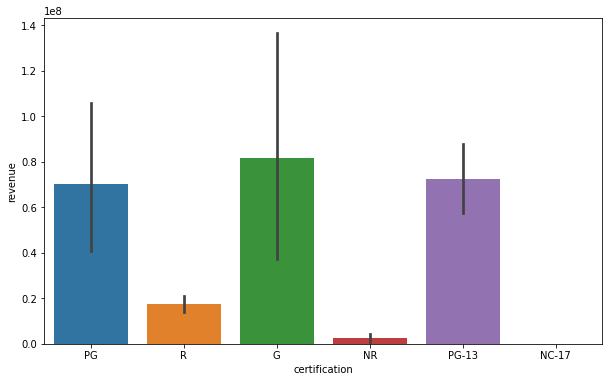

In [471]:
#visualization barplot of regions
plt.figure(figsize=(10,6))
sns.barplot(data=tmdb_results, x='certification',y='revenue');

**Question 2: Does the release year of a movie during the Covid-19 pandemic affect how much revenue a movie generated based on the year?**


*Null Hypothesis:* The release year of a movie, during the Covid-19 pandemic, has no significant affect on movie revenue based on the year.

*Alternative Hypothesis:* The release year of a movie, during the Covid-19 pandemic, has a significant affect on movie revenue based on the year.

Alpha = 0.05
*Covid-19 pandemic years = 2020, 2021, 2022*

In [454]:
#reviewing how release date values are arranged
df_combined['release_date'].unique()

array([nan, '2020-02-21', '2020-10-25', ..., '2022-10-17', '2019-08-31',
       '2022-08-30'], dtype=object)

In [455]:
#split release_date columns into year, month, day- will use year for hypothesis testing
df_combined[["Year", "Month", "Day"]] = df_combined["release_date"].str.split("-", expand = True)
df_combined.head(5)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,certification,Year,Month,Day
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,/fw5tsNib4QZBEw18xmebpVe3WZ8.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",http://poetastros.com/el-tango-del-viudo/,602986.0,es,El tango del viudo y su espejo deformante,"A man whose wife has committed suicide, appea...",...,Released,NaN,The Tango of the Widower and Its Distorting Mi...,0.0,5.300,3.0,NaN,2020,02,21
2,0.0,/8rIoyM6zYXJNjzGseT3MRusMPWl.jpg,NaN,0.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",https://www.thewitchesmovie.net/,531219.0,en,Roald Dahl's The Witches,"In late 1967, a young orphaned boy goes to liv...",...,Released,They're real!,Roald Dahl's The Witches,0.0,6.437,2305.0,PG,2020,10,25
3,0.0,/mwXmcrvjOJwzsJSuNEupjisXUt6.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",https://www.lostgirlslovehotels.film,479259.0,en,Lost Girls & Love Hotels,"Searching for escape in Tokyo's back alleys, a...",...,Released,NaN,Lost Girls & Love Hotels,0.0,5.200,120.0,R,2020,09,18
4,0.0,/op14w44FvLUqH7TWyT1ijzrSfXV.jpg,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",http://www.roadtored.com,651448.0,en,Darkslide,High in the Sierra Nevada Mountains of Califor...,...,Released,Keep Moving or Die,Darkslide,0.0,6.500,2.0,NaN,2016,11,17


In [456]:
#review year subtypes
df_combined['Year'].unique()

array([nan, '2020', '2016', '2021', '2019', '2022', '2018', '2017',
       '2013', '2012', '2015', '2014', '1999', '2008', '1989', '1994',
       '2023'], dtype=object)

In [457]:
year1 = df_combined.loc[df_combined['Year']== '2020'] 
year2 = df_combined.loc[df_combined['Year']== '2021']
year3 = df_combined.loc[df_combined['Year']== '2022']

In [459]:
#concat years into a single df
frames = [year1, year2, year3]
covid_years = pd.concat(frames)
covid_years.head(4)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,overview,...,status,tagline,title,video,vote_average,vote_count,certification,Year,Month,Day
1,0.0,/fw5tsNib4QZBEw18xmebpVe3WZ8.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",http://poetastros.com/el-tango-del-viudo/,602986.0,es,El tango del viudo y su espejo deformante,"A man whose wife has committed suicide, appea...",...,Released,NaN,The Tango of the Widower and Its Distorting Mi...,0.0,5.300,3.0,NaN,2020,02,21
2,0.0,/8rIoyM6zYXJNjzGseT3MRusMPWl.jpg,NaN,0.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",https://www.thewitchesmovie.net/,531219.0,en,Roald Dahl's The Witches,"In late 1967, a young orphaned boy goes to liv...",...,Released,They're real!,Roald Dahl's The Witches,0.0,6.437,2305.0,PG,2020,10,25
3,0.0,/mwXmcrvjOJwzsJSuNEupjisXUt6.jpg,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",https://www.lostgirlslovehotels.film,479259.0,en,Lost Girls & Love Hotels,"Searching for escape in Tokyo's back alleys, a...",...,Released,NaN,Lost Girls & Love Hotels,0.0,5.200,120.0,R,2020,09,18
5,0.0,/dzfiE2VHY362dGI62XfZ2iI87CT.jpg,NaN,7000000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 14, 'nam...",http://www.fantasyisland.movie/,539537.0,en,Fantasy Island,A group of contest winners arrive at an island...,...,Released,Never coming home,Fantasy Island,0.0,5.927,1995.0,PG-13,2020,02,12


In [460]:
#create groups dictionary.
groups = {}
## Loop through all unique categories
for i in covid_years['Year'].unique():
    ## Get series for group and rename
    data = covid_years.loc[covid_years['Year']==i,'revenue'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['2020', '2021', '2022'])

In [461]:
#remove outliers
for year, data in groups.items():
    outliers = np.abs(stats.zscore(data)) > 3
    print(f"there were {outliers.sum()} outliers in the {year} group")
    data = data.loc[~outliers]
    groups[year] = data

there were 9 outliers in the 2020 group
there were 27 outliers in the 2021 group
there were 11 outliers in the 2022 group


In [462]:
#test assumptions of normality and equal variance

#test normality
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
2020,3214.0,0.0,6375.306655
2021,3663.0,0.0,6003.085601
2022,1957.0,0.0,3161.272060


In [463]:
#review normality again using pandas
### checking sig with pandas 
norm_results_df['sig'] = norm_results_df['p'] < .05 
norm_results_df

#each group does not have a normal distribution

,n,p,test stat,sig
2020,3214.0,0.0,6375.306655,True
2021,3663.0,0.0,6003.085601,True
2022,1957.0,0.0,3161.272060,True


In [464]:
#test for equal variance

# with the * operator 
result = stats.kruskal(*groups.values())
result

#did not met assumption for equal variance

KruskalResult(statistic=9.980917054079605, pvalue=0.006802544626363126)

The null hypothesis must be rejected. P-value is less than 0.05 shows that there is significance in the data.

In [465]:
#test
#ANOVA

#hypothesis test
result = stats.f_oneway( *groups.values())
result

F_onewayResult(statistic=8.023233224909719, pvalue=0.00033015355597775485)

In [466]:
#interpret p-value and reject/fail to reject null hypothesis

print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue <.05}")

p-value=0.0003301536
Significant: True


The null hypothesis must be rejected as the p-value is greater than 0.05 which shows that there is significance in the data. The release year of a movie, during the Covid-19 pandemic or prior, had a significant affect on how much revenue a movie generated.

In [470]:
#visualization
values = covid_years['Year'].value_counts()
labels = ['2021', '2020', '2022']

circle_fig = go.Figure(data=[go.Pie(values=values, labels=labels, hole=0.3)])
circle_fig.update_layout(title_text='Percentage of Movies Released Per Year')
circle_fig.show()

print(values)

2021    3690
2020    3223
2022    1968
Name: Year, dtype: int64


**Question 3: Do rated R movies have a bigger budget than PG movies?**


*Null Hypothesis:* There is no significant difference in budget between R rated movies and PG rated movies.

*Alternative Hypothesis:* There is a significant difference in budget between R rated movies and PG rated movies.

Alpha = 0.05

In [424]:
#Separate the data into two groups (“kids” and “adults”)

kids = df_combined[df_combined['certification']=='PG']
adults = df_combined.loc[df_combined['certification']=='R']

print(f"There are {len(kids)} PG movies.")
print(f"There are {len(adults)} R movies.")

There are 184 PG movies.
There are 722 R movies.


In [428]:
#feature of interest is budget
kid_budget = kids['budget']
adult_budget = adults['budget']

In [429]:
#test assumptions

#Alpha is 0.05

#Independent 2 Sample T-Test Assumptions:
    #No significant outliers
    #Normality 
    #Equal Variance
    
#zscores and outliers
zscores= stats.zscore(kid_budget)
outliers= abs(zscores)>3
np.sum(outliers)

#no outliers in kid_budget

7

In [430]:
#Remove outliers from kid_budget
kid_budget = kid_budget[(np.abs(stats.zscore(kid_budget)) < 3)]

In [431]:
#Check for outlier in adult_budget
zscores= stats.zscore(adult_budget)
outliers = abs(zscores)>3
np.sum(outliers)

20

In [432]:
#Remove outliers from adult_budget
adult_budget = adult_budget[(np.abs(stats.zscore(adult_budget)) < 3)]

In [433]:
#Test for normality

#smoker_charges
result_kid_budget = stats.normaltest(kid_budget)
result_kid_budget

NormaltestResult(statistic=124.79395970922855, pvalue=7.967754819939942e-28)

In [434]:
result_kid_budget.pvalue < .05

True

In [435]:
#adult_budget
result_adult_budget = stats.normaltest(adult_budget)
result_adult_budget

NormaltestResult(statistic=557.4914204083652, pvalue=8.755404274550379e-122)

In [436]:
result_adult_budget.pvalue < .05

True

In [437]:
#Check Equal Variance

result = stats.levene(kid_budget, adult_budget)
result

LeveneResult(statistic=40.44678620296075, pvalue=3.248229143559733e-10)

In [438]:
#test

#Independent t-test with equal_var set to False
result = stats.ttest_ind(kid_budget, adult_budget, equal_var = False)
result

Ttest_indResult(statistic=3.691563185154329, pvalue=0.0002933908097823015)

In [439]:
#interpret p-value and reject/fail to reject null hypothesis

print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue <.05}")

p-value=0.0002933908
Significant: True


After checking assumptions and performing the test, the null hypothesis must be rejected. There is a significant difference between the budgets for a PG and R rated movie.

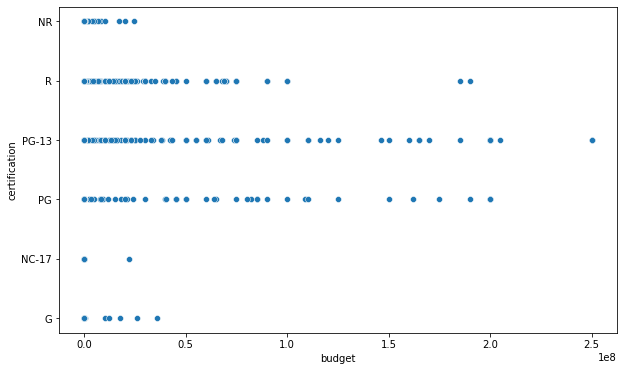

In [450]:
#visualization
plt.figure(figsize=(10,6))
sns.scatterplot(data=covid_years, x='budget',y='certification');